In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

In [23]:
# Path to Simulation/Results Folder
dataPath = 'RawData/'

In [24]:
def checkPathExists(path,createFolder=True):
  exists = False
  if path.endswith('/'):
    pathList = path.split('/')
    for i in np.arange(2,len(pathList)):
      subPath = '/'.join(pathList[:i])+'/'
      if not os.path.exists(subPath):
        if createFolder:
          print("Folder with the following location has been created: " + subPath)
          os.mkdir(subPath)
          exists = False
      else:
        exists = True
  else:
    if os.path.exists(path):
      exists = True
  return exists

In [25]:
def getFileNames(filePath):
  filenames=[]
  for filename in os.listdir(filePath):
    f = os.path.join(filePath, filename)
    filenames.append(f)
  return filenames

filenames_FO = np.sort(getFileNames(dataPath+"FiberOpticData/"))
filenames_FO = np.array(filenames_FO)[["gage" in f for f in filenames_FO]]
filenames_Tilt = np.sort(getFileNames(dataPath+"TiltMeterData/"))
filenames_Tilt = np.array(filenames_Tilt)[["csv" in f for f in filenames_Tilt]]
filenames_LVDTWP = np.sort(getFileNames(dataPath+"LVDTWirePotData/"))

OSError: [WinError 433] A device which does not exist was specified: 'RawData/FiberOpticData/'

In [26]:
def matchTimeSeries(newData,timeSeries):
  timeStepsDF = pd.DataFrame(data=timeSeries,columns=[newData.columns[0]],index=np.arange(newData.index.max()+1,newData.index.max()+1+len(timeSeries)))
  longData = pd.concat([newData,timeStepsDF])
  longData = longData.sort_values(newData.columns[0])
  longData = longData.interpolate(method="linear",axis=0,limit_direction='forward').dropna(axis=0)
  longData = longData.drop(newData.index,axis=0)
  return longData

In [27]:
# Read Fiber Optic Data
# Specify filename

def processFiberOpticData(filename_FO, saveFolder, nthPoint):
  saveFolder = saveFolder+"FiberOpticData/"
  checkPathExists(saveFolder)

  # Read Header Lines
  FOTestInfo = pd.read_csv(filename_FO,delimiter='\t',header=None,nrows=30)
  testName = FOTestInfo.iloc[0,1].replace(' ','')

  # Read Key information
  FODataHeaders = pd.read_csv(filename_FO,delimiter='\t',header=None,nrows=1,skiprows=np.arange(0,31).tolist()).drop([0,1,2],axis=1)
  FOTareValues = pd.read_csv(filename_FO,delimiter='\t',header=None,nrows=1,skiprows=np.arange(0,32).tolist()).drop([0,1,2],axis=1)
  FOLocValues = pd.read_csv(filename_FO,delimiter='\t',header=None,nrows=1,skiprows=np.arange(0,33).tolist()).drop([0,1,2],axis=1)
  FOData = pd.read_csv(filename_FO,delimiter='\t',header=None,skiprows=np.arange(0,34).tolist()).drop([1,2],axis=1)

  # Get Timesteps
  times = FOData.iloc[:,0].to_list()
  initTime = datetime.strptime(times[0], '%Y-%m-%d %H:%M:%S.%f')
  timeSteps = []
  for time in times:
    timeStep = datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f')-initTime
    timeSteps.append(timeStep.seconds+timeStep.microseconds/1e6)
  FOData = FOData.drop([0],axis=1)

  # Get start end Headers
  FOIndexHeaders = FODataHeaders[FODataHeaders.iloc[0,:].index[FODataHeaders.iloc[0,:].str.endswith(("E","I"))]]
  FOIndexLocs = FOLocValues[FODataHeaders.iloc[0,:].index[FODataHeaders.iloc[0,:].str.endswith(("E","I"))]]
  FOAllHeaders = FODataHeaders[FODataHeaders.iloc[0,:].index[FODataHeaders.iloc[0,:].str.startswith('All')]]
  FOAllLocs = FOLocValues[FODataHeaders.iloc[0,:].index[FODataHeaders.iloc[0,:].str.startswith('All')]]
  FOData = FOData[FODataHeaders.iloc[0,:].index[FODataHeaders.iloc[0,:].str.startswith('All')]]

  for index in FOIndexHeaders.columns.to_list():
    reverse = False
    if not index%2:
      continue
    # Find Start and End Locations for this element's fiberoptic
    startLoc = FOIndexLocs[index][0]
    endLoc = FOIndexLocs[index+1][0]
    elemName = FOIndexHeaders[index][0][:-2]

    #Ensure alphabetical order
    if elemName[0] > elemName[1]:
      reverse = True
      elemName = elemName[1::-1]+elemName[-2::]

    # Concatenate data and add Info
    dataIndexes = (FOAllLocs.iloc[0]>=min(startLoc,endLoc)) & (FOAllLocs.iloc[0]<=max(startLoc,endLoc))
    elemData = FOData[FOAllHeaders.iloc[0,:].index[dataIndexes]]
    elemHeaders = FOAllHeaders[FOAllHeaders.iloc[0,:].index[dataIndexes]]
    elemData.columns = elemHeaders.iloc[0,:].to_list()
    elemData.index = timeSteps

    # Remove initial value
    elemData = elemData.iloc[:,:]-elemData.iloc[0,:]

    # Reverse order of columns if necessary
    if [reverse + startLoc>endLoc]==1:
      elemData = elemData.reindex(columns=elemData.columns[::-1])

    # Fill missing Values
    elemData = elemData.interpolate(method="linear",axis=0,limit_direction='forward')

    # Reduce size for Github Size
    reducedElemData = elemData[elemData.columns[::nthPoint]]

    # Add fiberoptic length over time and dlength
    reducedElemData["TotalStrain [ue]"] = elemData.sum(axis=1,numeric_only=True)
    reducedElemData["AverageStrain [ue]"] = reducedElemData["TotalStrain [ue]"]/(len(elemData.columns.to_list())-1)
    reducedElemData = reducedElemData.reset_index(level=0,names=["Time"])

    reducedElemData.to_csv(saveFolder+elemName+".csv")
  print("FiberOptic data has been processed.")
  return timeSteps

In [8]:
def processLVDTWPLoadData(filename_LVDTWP,saveFolder,timeSteps):
  # Modify Loading, LVDT, and WirePot Data
  labData = pd.read_csv(filename_LVDTWP,delimiter="\t")
  labData = labData.drop(labData.columns[1],axis=1).astype(float)
  # Remove end of test extension
  labData = labData[labData.iloc[:,0]<=timeSteps[-1]+0.01]
  # Fix tim series to match FO
  labData = matchTimeSeries(labData,timeSteps)
  # Subtract out initial value
  labData = labData.iloc[:,:] - labData.iloc[0,:]
  # Fix column names
  labData.columns = ["Time [s]","LVDT1 [m]","LVDT2 [m]","LVDT3 [m]","LVDT4 [m]","LVDT5 [m]",
                    "LVDT6 [m]","LVDT7 [m]","LVDT8 [m]","ActuatorLoad [kN]", "ActuatorDisplacement [m]",
                    "WirePot4 [m]","WirePot2 [m]","WirePot3 [m]","WirePot1 [m]"]
  # Save data in process
  for column in labData.columns:
    if column == "ActuatorLoad [kN]":
      newSaveFolder = saveFolder+"LoadData/"
      factor = 4.44822162/1000
    elif column == "ActuatorDisplacement [m]":
      newSaveFolder = saveFolder+"LoadData/"
      factor = 1/39.3700787
    elif "WirePot" in column:
      newSaveFolder = saveFolder+"WirePotData/"
      factor = 1/39.3700787
    elif "LVDT" in column:
      newSaveFolder = saveFolder+"LVDTData/"
      factor = 1/39.3700787
    else:
      continue
    checkPathExists(newSaveFolder)
    labData[column]=labData[column]*factor
    labData[["Time [s]",column]].to_csv(newSaveFolder+column+".csv")
  print("Lab equipment data has been processed.")
  return None


In [10]:
def processTiltData(filename_Tilt, saveFolder,timeSteps,tiltDir=[1,1,1,1]):
  saveFolder = saveFolder+"TiltData/"
  checkPathExists(saveFolder)
  # Import Data
  tiltData = pd.read_csv(filename_Tilt,delimiter=',',header=None)

  # Remove logger box and Na values
  tiltData = tiltData.where(tiltData.iloc[:,2]!='9731').drop(columns=[15,16,17])
  tiltData = tiltData.dropna(axis=0)
  # Derive time values
  tiltData.iloc[:,0] = (tiltData.iloc[:,0]-tiltData.iloc[0,0])/1000
  # Sort Values
  tiltData = tiltData.sort_values([1,0])
  # Split Tilt Meter Data
  tiltData1 = tiltData[tiltData.iloc[:,1]==tiltData.iloc[0,1]]
  tiltData1ID = tiltData.iloc[0,1]
  tiltData2 = tiltData[tiltData.iloc[:,1]==tiltData.iloc[-1,1]]
  tiltData2ID = tiltData.iloc[-1,1]
  # Remove Unnecessary Columns
  tiltData1 = tiltData1.drop([1,2,3,4,5,6,7,8,9,10,11,12],axis=1)
  tiltData1.columns = ["Time","A-axis","B-axis"]
  tiltData2 = tiltData2.drop([1,2,3,4,5,6,7,8,9,10,11,12],axis=1)
  tiltData2.columns = ["Time","A-axis","B-axis"]
  # Match timeseries
  tiltData1 = matchTimeSeries(tiltData1,timeSteps)
  tiltData2 = matchTimeSeries(tiltData2,timeSteps)
  # Remove initial values
  tiltData1 = tiltData1.iloc[:,:] - tiltData1.iloc[0,:]
  tiltData2 = tiltData2.iloc[:,:] - tiltData2.iloc[0,:]
  for ID in [tiltData1ID,tiltData2ID]:
    index = 0
    tiltData = [tiltData1,tiltData2][index]
    index+=1
    if ID == "11408593":
      location = 'Front'
      tiltData["B-axis"] = tiltDir[0]*tiltData["B-axis"]
      tiltData["A-axis"] = tiltDir[1]*tiltData["A-axis"]
    elif ID == "1140859A":
      location = 'Back'
      tiltData["B-axis"] = tiltDir[2]*tiltData["B-axis"]
      tiltData["A-axis"] = tiltDir[3]*tiltData["A-axis"]
    tiltData.to_csv(saveFolder+location+".csv")
  print("Tilt meter data has been processed.")
  return None

In [15]:
tests = ["Test1/","Test2/","Test3/"]
saveFolder = 'ProcessedData/'
tiltDirs = -np.array([[1,1,-1,-1],[1,1,-1,-1],[1,1,-1,1]])
# Process Data
for fileIndex in [0,1,2]:
  #Process Channel 2 and 4 of FO data
  timeSteps = processFiberOpticData(filenames_FO[fileIndex], saveFolder+tests[fileIndex])

  #Process Lab Data
  processLVDTWPLoadData(filenames_LVDTWP[fileIndex],saveFolder+tests[fileIndex],timeSteps)

  #Process Tilt Data
  processTiltData(filenames_Tilt[fileIndex],saveFolder+tests[fileIndex],timeSteps,tiltDirs[fileIndex,:])

FiberOptic data has been processed.
Lab equipment data has been processed.
Tilt meter data has been processed.
FiberOptic data has been processed.
Lab equipment data has been processed.
Tilt meter data has been processed.
FiberOptic data has been processed.
Lab equipment data has been processed.
Tilt meter data has been processed.


In [12]:
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *

In [13]:
test_widget = widgets.SelectMultiple(options=['Test1', 'Test2', 'Test3'])
sensor_widget = widgets.Dropdown()
data_widget = widgets.SelectMultiple()

def update_sensors(*args):
  sourceFolder = 'ProcessedData/'
  try:
    newFolders = getFileNames(sourceFolder+test_widget.value+'/')
  except:
    newFolders = getFileNames(sourceFolder+'Test1/')
  options = [folder.split('/')[-1] for folder in newFolders]
  sensor_widget.options = options
test_widget.observe(update_sensors)

def update_data(*args):
  sourceFolder = 'ProcessedData/'
  try:
    newFolders = getFileNames(sourceFolder+test_widget.value[0]+'/'+sensor_widget.value+'/')
  except:
    newFolders = getFileNames(sourceFolder+'Test1/FiberOpticData/')
  options = np.sort(np.array([folder.split('/')[-1] for folder in newFolders])).tolist()
  data_widget.options = options
sensor_widget.observe(update_data)

plot = Checkbox(False, description='Ready to plot data?')
load = Checkbox(False, description='Ready to load data?')

def uncheckBox(*args):
  plot.value = False
  load.value = False
test_widget.observe(uncheckBox)
sensor_widget.observe(uncheckBox)
data_widget.observe(uncheckBox)
def plottingData(test,sensor,data,plotData,loadData):
  filePath = 'ProcessedData/'
  tests = list(test_widget.value)
  datas = list(data_widget.value)
  if (not tests) | (not datas):
    plotData = False
    print("Not enough information selected yet.")
  else:
    print("Enough information has been selected.")
  if plotData:
    legendItems = []
    dataDFs = []
    fig = plt.figure()
    ax = fig.gca()
    for test in tests:
      for data in datas:
        testFilePath = filePath + test +'/'+sensor_widget.value+'/'+data
        dataDF = pd.read_csv(testFilePath,delimiter=',',index_col=False)
        dataDF = dataDF.drop(columns = [dataDF.columns.to_list()[0]])
        dataDFs.append(dataDF)
        plt.plot(dataDF.iloc[:,0],dataDF.iloc[:,-1])
        legendItems.append(test+data)
    plt.xlabel(dataDF.columns.to_list()[0])
    plt.ylabel(dataDF.columns.to_list()[-1])
    ax.grid(color = [0.8, 0.8, 0.8], which = 'major')
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(direction="in", which = 'major', length = 6, width = 1)
    ax.tick_params(direction="in", which = 'minor', length = 3, width = 0.6)
    ax.set_title('Data vs. Time', fontsize = 14)
    plt.legend(legendItems)
    plt.show()
  else:
    print("Change the options and then check the box to load the graph.")
  if loadData:
    return dataDFs

interactiveData = interactive(plottingData,
                              test=test_widget,
                              sensor=sensor_widget,
                              data=data_widget,
                              plotData = plot,
                              loadData = load)

In [14]:
display(interactiveData)

interactive(children=(SelectMultiple(description='test', options=('Test1', 'Test2', 'Test3'), value=()), Dropd…

In [38]:
newFOFile = "ProcessedData/Test1/FiberOpticData/FG_U.csv"

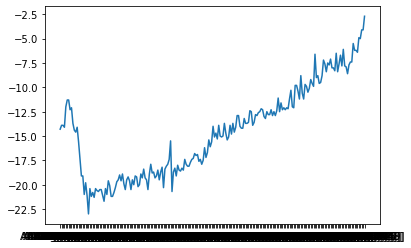

In [41]:
test = pd.read_csv(newFOFile)
plt.plot(test.iloc[200,3:-3])

In [254]:
display(interactiveData)

interactive(children=(SelectMultiple(description='test', index=(2,), options=('Test1', 'Test2', 'Test3'), valu…

In [29]:
test

,Unnamed: 0,Time,All Gages[5826],All Gages[5827],All Gages[5828],All Gages[5829],All Gages[5830],All Gages[5831],All Gages[5832],All Gages[5833],...,All Gages[6114],All Gages[6115],All Gages[6116],All Gages[6117],All Gages[6118],All Gages[6119],All Gages[6120],All Gages[6121],TotalStrain [ue],AverageStrain [ue]
0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,0.100065,-0.6,-1.0,-0.5,0.7,0.3,0.5,-0.9,-0.8,...,0.9,0.0,0.4,-0.1,0.0,-0.7,0.0,0.0,-40.6,-0.137162
2,2,0.200130,0.2,-0.6,-0.6,-0.5,0.2,0.6,-0.2,-0.5,...,-0.6,-1.1,0.2,0.0,0.9,-1.0,0.9,0.3,-70.8,-0.239189
3,3,0.300195,-0.1,0.0,-1.4,-1.1,0.1,-0.1,-0.5,-0.7,...,-1.1,-0.5,0.2,-0.1,0.3,-0.9,-0.4,-0.2,-116.6,-0.393919
4,4,0.400259,-0.8,-1.1,-1.4,-1.2,0.0,-0.2,-0.5,-1.2,...,-0.1,-0.4,0.3,0.0,0.4,-0.5,0.0,0.7,-135.3,-0.457095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2853,2853,323.609718,218.0,255.9,283.1,314.5,343.8,362.5,376.9,389.5,...,411.9,389.8,367.4,337.3,303.9,270.7,231.4,192.7,142480.8,481.354054
2854,2854,323.709783,218.0,255.9,283.1,314.5,343.8,362.5,376.9,389.5,...,411.9,389.8,367.4,337.3,303.9,270.7,231.4,192.7,142480.8,481.354054
2855,2855,323.909913,218.0,255.9,283.1,314.5,343.8,362.5,376.9,389.5,...,411.9,389.8,367.4,337.3,303.9,270.7,231.4,192.7,142480.8,481.354054
2856,2856,324.009978,218.0,255.9,283.1,314.5,343.8,362.5,376.9,389.5,...,411.9,389.8,367.4,337.3,303.9,270.7,231.4,192.7,142480.8,481.354054


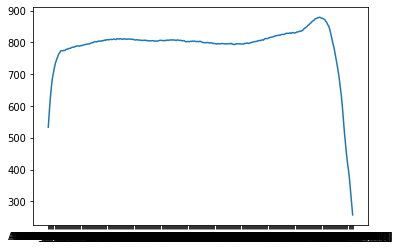